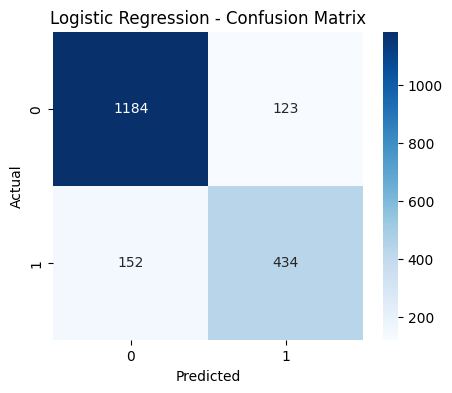

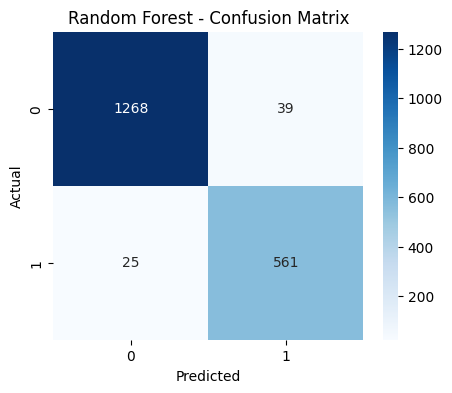

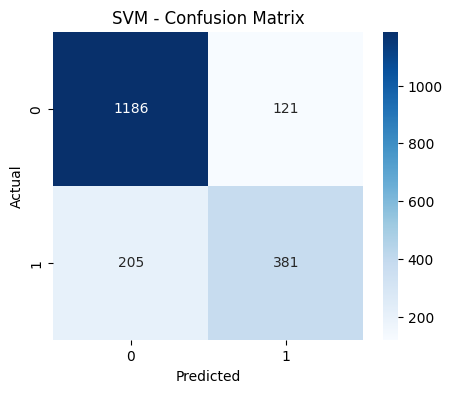

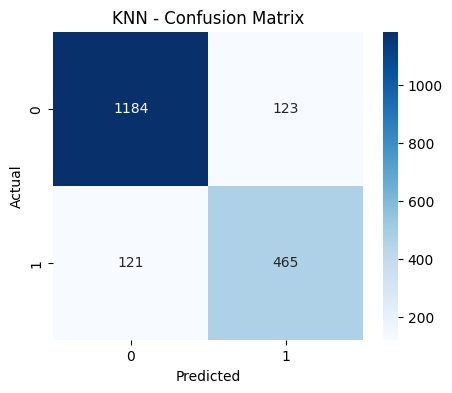


Model Accuracies:
Logistic Regression: 0.8547
Random Forest: 0.9662
SVM: 0.8278
KNN: 0.8711


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import pickle

# Load the dataset
data = pd.read_csv('synthetic_access_data_10000.csv')

# Select only the needed columns
columns_to_use = ['user_role', 'department', 'employee_status', 'resource_type', 'resource_sensitivity', 'employee_join_date', 'past_violations', 'is_approved']
data = data[columns_to_use]

# Drop rows with missing values
data.dropna(inplace=True)

# Feature engineering: derive time spent in months
current_date = pd.to_datetime('today')
data['employee_join_date'] = pd.to_datetime(data['employee_join_date'], errors='coerce')
data.dropna(subset=['employee_join_date'], inplace=True)
data['time_spent_months'] = (current_date - data['employee_join_date']).dt.days // 30

# Drop the original 'employee_join_date'
data.drop('employee_join_date', axis=1, inplace=True)

label_encoders = {}
categorical_cols = ['user_role', 'department', 'employee_status', 'resource_type', 'resource_sensitivity']
for col in categorical_cols:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])  # Fit on original strings
    label_encoders[col] = le  # Save the encoder

    
# Define features and target
X = data.drop('is_approved', axis=1)
y = data['is_approved']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define models to train
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'SVM': SVC(probability=True, random_state=42),
    'KNN': KNeighborsClassifier()
}

accuracies = {}

# Train and evaluate models
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    accuracies[name] = acc

    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{name} - Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Print all accuracies
print("\nModel Accuracies:")
for name, acc in accuracies.items():
    print(f"{name}: {acc:.4f}")


In [2]:
# Save the model and encoders
with open('random_forest_model_new.pkl', 'wb') as model_file:
    pickle.dump(models['Random Forest'], model_file)

with open('label_encoders.pkl', 'wb') as encoders_file:
    pickle.dump(label_encoders, encoders_file)

In [3]:
#FINALLL MODELLLL PREDICTIONNNN


import pickle
import pandas as pd
from datetime import datetime

# Load the saved Random Forest model and label encoders
with open('random_forest_model_new.pkl', 'rb') as model_file:
    model = pickle.load(model_file)

with open('label_encoders.pkl', 'rb') as encoders_file:
    label_encoders = pickle.load(encoders_file)

# Dummy data for a single user
user_data = {
    'user_role': 'Admin',
    'department': 'IT',
    'employee_status': 'Terminated',
    'resource_type': 'doc',
    'resource_sensitivity': 'restricted',
    'employee_join_date': '02-04-2020',
    'past_violations': 0
}

# Convert to DataFrame
user_df = pd.DataFrame([user_data])

# Preprocess the data (use saved encoders for consistency)
categorical_cols = ['user_role', 'department', 'employee_status', 'resource_type', 'resource_sensitivity']
for col in categorical_cols:
    le = label_encoders[col]
    # Handle unseen categories if necessary
    if user_df[col].iloc[0] not in le.classes_:
        # Option 1: Assign a default value (e.g., 'Unknown')
        # Option 2: Raise an error or handle as needed
        user_df[col] = 'Unknown'  # Example handling
    user_df[col] = le.transform(user_df[col])

# Feature engineering: derive time spent in months
current_date = pd.to_datetime('today')
user_df['employee_join_date'] = pd.to_datetime(user_df['employee_join_date'], errors='coerce')
user_df['time_spent_months'] = (current_date - user_df['employee_join_date']).dt.days // 30

# Drop the original 'employee_join_date'
user_df.drop('employee_join_date', axis=1, inplace=True)

# Predict using the Random Forest model
prediction = model.predict(user_df)
probability = model.predict_proba(user_df)

# Output the result
print(f"Prediction: {'Approved' if prediction[0] == 1 else 'Not Approved'}")
print(f"Probability: {probability[0]}")

Prediction: Not Approved
Probability: [0.99 0.01]
